In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from codes.single_measurement_vector import single_measurement_vector
from codes.residual_ratio_thresholding import residual_ratio_thresholding


# Problem Statement

Consider a single measurement vector (SMV) linear regression model ${\bf Y}={\bf X}{\bf B}+{\bf W}$ where ${\bf X} \in \mathbb{R}^{nsamples\times nfeatures} $ is a known design matrix and ${\bf B} \in \mathbb{R}^{nfeatures\times 1}$ is an unknown vector with $sparsity=\|{\bf B}\|_0\ll nfeatures$. ${\bf W} \in \mathbb{R}^{nsamples\times 1}$ is a noise vector (for theoretical purposes only) assumed to be a noise vector with each entries assumed to $\mathcal{N}(0,\sigma^2)$ distributed. 

The problem we address here is the estimation of ${\bf B}$ when $sparsity$ and $\sigma^2$ are both unknown. We consider a high dimensional scenario where $nsamples\ll nfeatures$. Under these constraints, it is difficult to estimate ${\bf B}$ with finite sample guarantees.  Most (not all) popular algorithms including OMP, LASSO, subspace pursuit, Dantzig selector etc. can deliver estimation  with theoretical (especially restricted isometry property ) guarantees require $\textit{a priori}$ knowledge of sparsity and/or $\sigma^2$

In our 2018 ICML paper http://proceedings.mlr.press/v80/kallummil18a.html we proposed residual ratio thresholding as a tool to estimate ${\bf B}$ using OMP without requiring $\textit{a priori}$ knowledge of sparsity and/or $\sigma^2$. This concept was later extended in a recent article (https://arxiv.org/pdf/1912.08637.pdf under review in IEEE TSP) to operate LASSO without requiring $\textit{a priori}$ knowledge of sparsity and/or $\sigma^2$.
Here, we illustrate  how to use residual ratio thresholding in SMV scenarios. 


# Generate a training example
with sparsity=5,design matrix X sampled from a Gaussian ensemble with $l_2$ normalized columns. 


In [2]:
smv=single_measurement_vector();
X,Y,Beta_true,support_true,noisevar=smv.generate_random_example(nsamples=32,nfeatures=64,sparsity=3,SNR_db=20)
print('Unknown sparse vector Beta is')
print(Beta_true.flatten())
print('Support of Beta is')
print(support_true)

Unknown sparse vector Beta is
[-1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Support of Beta is
[0, 1, 2]


# Generate residual ratio statistic res_ratio(k)
we can use our preferred algorithm to generate residual statistic. In fact any algorithm that can give an estimate of $\hat{\bf B}=Alg(X,Y,k)$ with sparsity of $\hat{\bf B}$ can be used to generate residual ratio statistic. The support estimate sequence $supp_k=\[\k:\hat{\bf B}[k]~=0\]$ may not be monotonically increasing with $k$ for algorithms like LASSO. For OMP this sequence is monotonic always. Such non monotonic sequences have to be converted into monotonic sequences before producing residual ratios. 

We use OMP and LASSO to generate the statistic. Please see the paper for more details. 



[0, 2, 1, 49, 37, 26, 19, 14, 36, 48, 55, 32, 12, 50, 27, 63]
[0, 2, 1, 26, 32, 22, 14, 35, 27, 57, 24, 36, 59, 63, 53, 33]


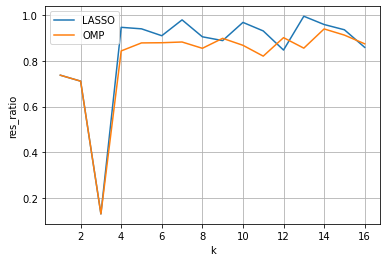

In [3]:
plt.figure()
res_ratio,ordered_support_estimate_sequence=smv.generate_residual_ratios(X,Y,'LASSO')
print(ordered_support_estimate_sequence)
plt.plot(np.arange(len(res_ratio))+1,res_ratio,label='LASSO')


res_ratio1,ordered_support_estimate_sequence1=smv.generate_residual_ratios(X,Y,'OMP')
print(ordered_support_estimate_sequence1)
plt.plot(np.arange(len(res_ratio))+1,res_ratio1,label='OMP')
plt.grid()
plt.xlabel('k'); plt.ylabel('res_ratio')
plt.legend()

# Behaviour of Residual Ratios
As one can see from the above plot, when the ordered_support_estimate_sequence covers the true support at k=true sparsity, one can see that there is a dip in the res_ratio statistic. ordered_support_estimate_sequence[:sparisty]=true_support under standard matrix and SNR assumptions for most algorithms. 

Suppose one can identify a threshold sequence such that $residual_ratio[k]>threshold[k]$  for all $k>sparsity$ then 
$$\hat{sparsity}=\max\{k:res-ratio[k]<threshold[k]\} $$, then one can identify the sparsity level from the residual ratio. 

Residual ratio thresholding develops such scenario specific thresholds. These thresholds are parameterized by a parameter $\alpha$. For all practical purposes $\alpha$ can be set to $0.1$. As one can see from below plot these sequence of thresholds satisfy $residual_ratio[k]>threshold[k]$  for all $k>sparsity$. 

In [9]:
rrt=residual_ratio_thresholding(nsamples=32,nfeatures=64,
                                        alpha_list=[0.1,0.01,0.001],nchannels=1, group_size=1,scenario='compressed_sensing:SMV')

results=rrt.estimate_support(ordered_support_estimate_sequence,res_ratio) 
tres1=rrt.threshold_dict[0.1]['direct']
tres2=rrt.threshold_dict[0.01]['direct']
tres3=rrt.threshold_dict[0.001]['direct']

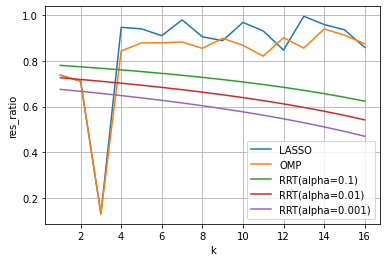

In [12]:
plt.figure()

plt.plot(np.arange(len(res_ratio))+1,res_ratio,label='LASSO')
plt.plot(np.arange(len(res_ratio))+1,res_ratio1,label='OMP')
plt.plot(np.arange(len(tres1))+1,tres1,label='RRT(alpha=0.1)')
plt.plot(np.arange(len(tres1))+1,tres2,label='RRT(alpha=0.01)')
plt.plot(np.arange(len(tres1))+1,tres3,label='RRT(alpha=0.001)')

plt.grid()
plt.xlabel('k'); plt.ylabel('res_ratio')
plt.legend()

# How to use RRT

${\bf Step 1:}$ Generate res_ratios, ordered_support estimate using any sparse recovery algorithm. We used LASSO and OMP for this purpose in single_measurement_vector.py file. 

example: res_ratio,ordered_support_estimate_sequence=smv.generate_residual_ratios(X,Y,'LASSO')

${\bf Step 2:}$ Instantiate RRT using the problem dimensions and desired values of alpha. 

rrt=residual_ratio_thresholding(nsamples=32,nfeatures=64,alpha_list=[0.1,0.01,0.001],nchannels=1,group_size=1,scenario='compressed_sensing:SMV')

For SMV models, use this format itself. Keep nchannels=1,group_size=1 and scenario='compressed_sensing:SMV'. We can generate different thresholds for different scenarios like Robust regression, Group sparsity etc by varying these parameters. 

${\bf Step 3}$: estimate the sparsity level from the res ratio sequence using RRT 

results=rrt.estimate_support(ordered_support_estimate_sequence,res_ratio) 

results[alpha] gives the support estimate corresponding to RRT  with alpha as a hyper parameter if alpha is present in alpha_list

${\bf Step 4}$: Generate the least squares estimate of ${\bf B}$ corresponding to estimated support. 

Beta_estimate=smv.generate_estimate_from_support(X,Y,support=results[alpha])




In [16]:
rrt=residual_ratio_thresholding(nsamples=32,nfeatures=64,
                                        alpha_list=[0.1,0.01,0.001],nchannels=1, group_size=1,scenario='compressed_sensing:SMV')

results=rrt.estimate_support(ordered_support_estimate_sequence,res_ratio)
results1=rrt.estimate_support(ordered_support_estimate_sequence1,res_ratio1)
print('True_support')
print(support_true)
print('Estimated_support:LASSO')
print(results[0.1])
print('Estimated_support:OMP')
print(results1[0.1])
Beta_est=smv.generate_estimate_from_support(X,Y,support=results[0.1])
Beta_est1=smv.generate_estimate_from_support(X,Y,support=results1[0.1])

print('Beta_true,Beta_est(LASSO+RRT),Beta_est(OMP+RRT)')
print(np.hstack([Beta_true,Beta_est,Beta_est1]))

True_support
[0, 1, 2]
Estimated_support:LASSO
[0, 2, 1]
Estimated_support:OMP
[0, 2, 1]
Beta_true,Beta_est(LASSO+RRT),Beta_est(OMP+RRT)
[[-1.         -0.99642629 -0.99642629]
 [ 1.          0.93921146  0.93921146]
 [ 1.          1.00848028  1.00848028]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.

# Evaluating performance. 

We compare the performanc of OMP and LASSO operated using RRT against a simple baseline. An oracle that knows the true support a priori. Except at low SNR, LASSO and OMP operated using RRT matches the support aware oracle. In our papers, we compare RRT with OMP and LASSO provided with a priori knowledge of sparsity and $\sigma^2$. IN most of our experiments, we found that the performance GAP between OMP/LASSO with a priori known sparsity and noise variance is 

Text(0, 0.5, 'l2_error')

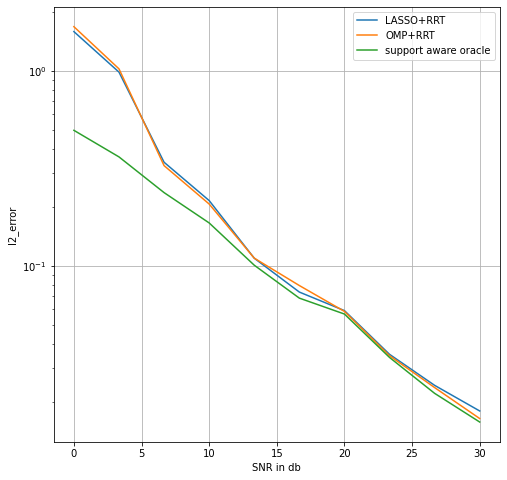

In [21]:
SNR_db=np.linspace(0,30,10)
L2_ERROR_LASSO=np.zeros(10); L2_ERROR_OMP=np.zeros(10);L2_ERROR_BASELINE=np.zeros(10)
smv=single_measurement_vector();
rrt=residual_ratio_thresholding(nsamples=32,nfeatures=64,
                                        alpha_list=[0.1],nchannels=1, group_size=1,scenario='compressed_sensing:SMV')


num_iter=100; # number of montecarlo iterations for each example. 
for s in np.arange(len(SNR_db)):
    snr_db=SNR_db[s]
    l2_error_lasso=0;l2_error_omp=0;l2_error_baseline=0;
    for num in np.arange(num_iter):
        X,Y,Beta_true,support_true,noisevar=smv.generate_random_example(nsamples=32,nfeatures=64,
                                                                        sparsity=3,SNR_db=snr_db)
        res_ratio_lasso,ordered_support_estimate_sequence_lasso=smv.generate_residual_ratios(X,Y,'LASSO')
        res_ratio_omp,ordered_support_estimate_sequence_omp=smv.generate_residual_ratios(X,Y,'OMP')
        results_lasso=rrt.estimate_support(ordered_support_estimate_sequence_lasso,res_ratio_lasso)
        results_omp=rrt.estimate_support(ordered_support_estimate_sequence_omp,res_ratio_omp)
        Beta_est_lasso=smv.generate_estimate_from_support(X,Y,support=results_lasso[0.1])
        Beta_est_omp=smv.generate_estimate_from_support(X,Y,support=results_omp[0.1])
        support_error,l2_error=smv.compute_error(support_true=support_true,support_estimate=results_lasso[0.1],
                                                 Beta_true=Beta_true,Beta_estimate=Beta_est_lasso)
        l2_error_lasso+=l2_error

        support_error,l2_error=smv.compute_error(support_true=support_true,support_estimate=results_omp[0.1],
                                                 Beta_true=Beta_true,Beta_estimate=Beta_est_omp)
        l2_error_omp+=l2_error
        
        Beta_est_baseline=smv.generate_estimate_from_support(X,Y,support=support_true)
        support_error,l2_error=smv.compute_error(support_true=support_true,support_estimate=support_true,
                                                 Beta_true=Beta_true,Beta_estimate=Beta_est_baseline)
        l2_error_baseline+=l2_error
        
    L2_ERROR_LASSO[s]=l2_error_lasso/num_iter;L2_ERROR_OMP[s]=l2_error_omp/num_iter;L2_ERROR_BASELINE[s]=l2_error_baseline/num_iter

plt.figure(figsize=(8,8))
plt.semilogy(SNR_db,L2_ERROR_LASSO,label='LASSO+RRT')
plt.semilogy(SNR_db,L2_ERROR_OMP,label='OMP+RRT')
plt.semilogy(SNR_db,L2_ERROR_BASELINE,label='support aware oracle')
plt.grid()
plt.legend()
plt.xlabel('SNR in db')
plt.ylabel('l2_error')  